##  This NoteBook contains score improvement for data preparation feature engineering, model training/validation for ML Task of DB Schenker

### Improvement strategy
 - Feature Engg.- Create richer features around lat-lon features and dates
 - Reduce overfitting issue
 - Create different models and lastly stacking

### Following are the assumptions

- As I don't know the normalization method of weight, loading_meters, and cost, I used the features as it is w/o any transformation
- The final cost_prediction.csv file contains the predictions with same order w.r.t. the provided test_data.csv
- skipping EDA here as already done and focussing on the implementation

##### Validation data R2 score: 0.8425

#### Adding imports

In [31]:
import os
import math
import pickle
import sys
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import plot_importance
import pickle
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,cross_validate,GridSearchCV,RandomizedSearchCV
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler,PowerTransformer
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from vincenty import vincenty
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import requests
from shapely.geometry import mapping, shape
from shapely.prepared import prep
from shapely.geometry import Point
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

## Loading data frame and having a look at the data and checking for any missing value

In [3]:
data_frame = pd.read_csv('../data/train_data.csv',sep=';', parse_dates=['shipping_date'])
data_frame['shipping_date'] = pd.to_datetime(data_frame['shipping_date'])
display(data_frame.head())
data_frame.describe()

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost
0,27.22,105.59,26.91,108.67,0.513,0.195,True,2017-04-24,0.247
1,25.00,109.79,25.34,108.59,0.484,0.195,True,2017-07-27,0.248
2,27.10,105.60,29.35,106.54,0.484,0.195,True,2017-02-03,0.276
3,24.72,106.25,23.43,109.78,0.504,0.195,True,2017-04-03,0.276
4,22.33,108.37,29.38,111.50,0.484,0.195,True,2018-11-08,0.553


,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,cost
count,251155.000000,251155.000000,251155.000000,251155.000000,251155.000000,251155.000000,251155.000000
mean,25.698019,108.928965,25.583530,108.969093,0.405943,0.167496,0.343925
std,1.783849,2.086520,1.983605,2.297844,0.127647,0.063195,0.129915
min,21.710000,102.970000,21.650000,103.000000,0.050000,0.000000,0.017000
25%,24.310000,107.340000,23.780000,107.180000,0.328000,0.195000,0.249000
50%,25.650000,108.890000,25.640000,109.400000,0.475000,0.195000,0.333000
75%,26.910000,110.460000,27.170000,110.750000,0.490000,0.195000,0.415000
max,30.220000,114.210000,30.400000,114.250000,1.000000,0.995000,2.349000


In [4]:
display(data_frame.info())
data_frame.is_adr.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251155 entries, 0 to 251154
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   origin_latitude        251155 non-null  float64       
 1   origin_longitude       251155 non-null  float64       
 2   destination_latitude   251155 non-null  float64       
 3   destination_longitude  251155 non-null  float64       
 4   weight                 251155 non-null  float64       
 5   loading_meters         251155 non-null  float64       
 6   is_adr                 251155 non-null  bool          
 7   shipping_date          251155 non-null  datetime64[ns]
 8   cost                   251155 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(7)
memory usage: 15.6 MB


None

True    251155
Name: is_adr, dtype: int64

### There in no requirement of missing value treatment
### Only one class for is_adr categorical variable, so the feature is not useful

In [5]:
target = 'cost'
lat_1,lon_1,lat_2,lon_2 = 'origin_latitude','origin_longitude','destination_latitude','destination_longitude'
X = data_frame.drop([target],axis=1)
Y = data_frame[target]

## Creating a class to first create new features for ML training- Feature Engg.

### Following feature might usefull for the model:
 - From start and end lat-lon a few distence features,central tendency and directional features
 - Identify country and inter country movement
 - A few date-time/time series features(week-day,month,count_day etc.) from 'shipping_date'to capture effect of possible seasonality 

### creating a class here with a few methods, so that it can be used as an single object during inference time and also have inheritence property

In [41]:
class FeatenggTransformer(BaseEstimator, RegressorMixin, TransformerMixin):

    def transform(self, X):
        
        """This pipeline transforms the dataframe to the desired
         features and shape"""

        X = self.add_date_feature(X)
        X = self.add_travel_features(X)
        X = self.get_country_feats(X)
        X = self.drop_unrequired_fields(X)
        return X

    def add_travel_features(self, X):

        """This Method creates distance features and directional/angular features(bearing)"""
        
        X['abs_diff_longitude'] = (X[lon_2] - X[lon_1]).abs()
        X['abs_diff_latitude'] = (X[lat_2] - X[lat_1]).abs()
        X['Vincenty_distance'] = X.apply(lambda x: vincenty((x[lat_1], \
            x[lon_1]), (x[lat_2], x[lon_2])\
                ,miles=True), axis = 1)

        # bearing (in degrees converted to radians)
        def bearing_array(lat1, lng1, lat2, lng2):
            AVG_EARTH_RADIUS = 6371  # in km
            lng_delta_rad = np.radians(lng2 - lng1)
            lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
            y = np.sin(lng_delta_rad) * np.cos(lat2)
            x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
            return np.degrees(np.arctan2(y, x))

        X['Bearing'] = bearing_array(X[lat_1], \
                    X[lon_1], X[lat_2], X[lon_2])
        X.loc[:, 'center_latitude'] = (X[lat_1].values + X[lat_2].values) / 2
        X.loc[:, 'center_longitude'] = (X[lon_1].values + X[lon_2].values) / 2
        return X

    def add_date_feature(self, X):
        
        """This Method creates time series/date features"""
        
        ref_date = '2017-01-01'
        X['weekday'] = X['shipping_date'].dt.day_of_week
        X["is_weekend"] = np.where(X["weekday"] < 5, 0, 1)
        X['week_in_month'] = pd.to_numeric(X['shipping_date'].dt.day/7).\
        apply(lambda x: math.ceil(x))
        X['month'] = X['shipping_date'].dt.month
        X['day_count'] = (X['shipping_date'] - datetime.strptime(ref_date, "%Y-%m-%d"))/np.timedelta64(1, 'D')
        return X

    def get_country_feats(self, X):
        data = requests.get("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson").json()
        countries = {}
        for feature in data["features"]:
            geom = feature["geometry"]
            country = feature["properties"]["ADMIN"]
            countries[country] = prep(shape(geom))
        def get_country(row):
            point = Point(row[0], row[1])
            for country, geom in countries.items():
                if geom.contains(point):
                    return country
            return "unknown"
        X['destn_country'] = X[[lon_2,lat_2]].apply(get_country,axis=1)
        X['origin_country'] = X[[lon_1,lat_1]].apply(get_country,axis=1)
        X['diff_country'] = np.where(X['origin_country'] == X['destn_country'],0,1) 
        return X   

    def drop_unrequired_fields(self, X):

        """Method for dropping unrequired fields"""

        return X.drop(['shipping_date','is_adr',lat_1,lon_1,lat_2,lon_2], axis=1)



In [7]:
fet =  FeatenggTransformer()
X = fet.transform(X)
X.head()

,weight,loading_meters,weekday,is_weekend,week_in_month,month,day_count,abs_diff_longitude,abs_diff_latitude,Vincenty_distance,Bearing,center_latitude,center_longitude,destn_country,origin_country,diff_country
0,0.513,0.195,0,0,4,4,113.0,3.08,0.31,191.037834,95.746206,27.065,107.130,China,China,0
1,0.484,0.195,3,0,4,7,207.0,1.20,0.34,78.727542,-72.362269,25.170,109.190,China,China,0
2,0.484,0.195,4,0,1,2,33.0,0.94,2.25,165.204863,19.988087,28.225,106.070,China,China,0
3,0.504,0.195,0,0,1,4,92.0,3.53,1.29,240.063491,111.087172,24.075,108.015,China,China,0
4,0.484,0.195,3,0,2,11,676.0,3.13,7.05,522.933371,21.111657,25.855,109.935,China,China,0


## Feature Transformation

- A) One-Hot Encoding: For these categorical variables there no definite ordinal relationship exists,so the integer encoding(LabelEncoder/LabelBinarizer) is not enough. 

In [44]:
#Segregate Categorical and Numerical features

cat_cols = ['week_in_month', 'weekday', 'is_weekend', 'month','destn_country','origin_country']
num_cols = [col for col in list(X.columns) if col not in cat_cols]
print(num_cols)

['weight', 'loading_meters', 'day_count', 'abs_diff_longitude', 'abs_diff_latitude', 'Vincenty_distance', 'Bearing', 'center_latitude', 'center_longitude', 'diff_country']


In [45]:
class FeatureTransformer(BaseEstimator, RegressorMixin, TransformerMixin):

    """This Class is for FeatureTransform
        a) categorical feature encoding
    """
    
    def __init__(self,cat_cols,num_cols,path):
        self.cat_cols,self.num_cols,self.path = cat_cols,num_cols,path
        if not os.path.exists(self.path):
            os.mkdir(self.path)
    def transform(self, X):

        """This pipeline transforms the categorical features to One-Hot Encoded and scales the 
         features"""

        X = self.encode_categorical(X)
        return X

    def encode_categorical(self, X):

        """This Method creates absolute difference features
        and Serializes(pickle) the necessary objects for inference"""

        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        ohe.fit(X[self.cat_cols])
        x_cat_df = pd.DataFrame(ohe.transform(X[self.cat_cols]))
        x_cat_df.columns = ohe.get_feature_names_out(self.cat_cols)
        X = pd.concat([X[num_cols],x_cat_df],axis=1)
        with open(os.path.join(self.path,'ohe.pkl') ,'wb') as fout:
            pickle.dump(ohe, fout)
        return X
        

In [46]:
ft = FeatureTransformer(cat_cols=cat_cols,num_cols=num_cols,path='../artifacts_final/')
X_transformed = ft.transform(X)
print(X_transformed.shape)

(251155, 40)



### Before modelling let's explore interesting patterns/correlation between the numerical variables and cost

weight               -0.051613
loading_meters        0.048427
day_count             0.081131
abs_diff_longitude    0.596514
abs_diff_latitude     0.521753
Vincenty_distance     0.781482
Bearing              -0.005725
center_latitude       0.077604
center_longitude      0.029399
diff_country          0.070505
Name: cost, dtype: float64

<AxesSubplot:>

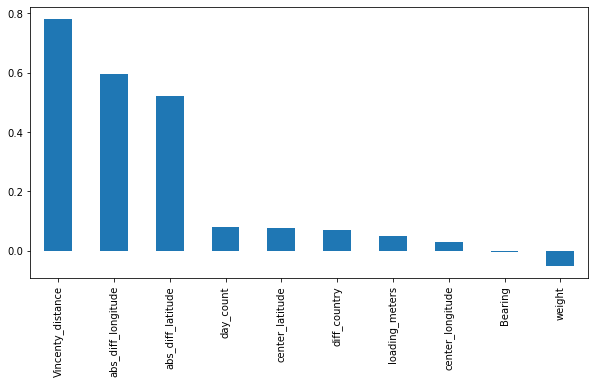

In [12]:
plt.figure(figsize=(10,5))
display(pd.concat([X_transformed[num_cols],Y],axis=1).corr()['cost'][:-1])
pd.concat([X_transformed[num_cols],Y],axis=1).corr()['cost'][:-1].sort_values(ascending = False).plot(kind='bar')
# plt.show()

### As expected very high +ve correlation between cost and distance(as reflected for abs_diff_longitude and abs_diff_latitude as well).
### Surprisingly there is no or little correlation for loading_meters and weight.

## Model Improvement and Fine Tuning

#### Create different high performing base models
 - XGBoost Model optimization- through grid serach hyperparameter tuning(Boosting)
 - LightGBM Model optimization- through Random grid serach hyperparameter tuning(Boosting)
 - Random Forrest Model optimization- through Random grid serach hyperparameter tuning(Bagging)

#### Model Stacking
 - Model Stacking Using StackingRegressor from sklearn with LinearRegression final_estimator

#### As key evaluation metric, relevant for this business problem here we try to maximize R-Squared score.


#### XGBoost Model optimization

In [ ]:
model_path = '../artifacts_final'

# Data split
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, Y, test_size=0.2, random_state=101)

#GridSearch
paramGrid = {'max_depth': [5,6,7],'subsample': [0.7,0.8], 'colsample_bytree': [0.4,0.7,0.8], 'learning_rate':[0.05],'n_estimators':[300],
              'seed':[100],'gamma':[0.05,0.01]}
xgb_model = XGBRegressor(eval_metric = 'rmse',objective='reg:squarederror',early_stopping_rounds=30)
GV = GridSearchCV(xgb_model, paramGrid, verbose=False,scoring='r2',
         cv=3,refit=True)
GV.fit(X_train, y_train,eval_set = [(X_valid, y_valid)])
print(f' Best Model Parameter {GV.best_params_}')
print(f' Best Model CV score {GV.best_score_}')
print(f'selecting the best Hyperparameter tuned estimator with {GV.best_params_}')  
xgb_model = GV.best_estimator_

#Fitting the Best Model with controlled n_estimators
xgb_model.n_estimators = 3000
xgb_model.fit(X_train, y_train,verbose=2,\
            eval_set=[(X_train, y_train), (X_valid, y_valid)]) 

#Validation
pred = xgb_model.predict(X_valid)
print(r2_score(y_valid,pred))
mean_absolute_percentage_error(y_valid,pred)
with open(os.path.join(model_path,'xgb_model.pkl'), 'wb') as fout:
    pickle.dump(xgb_model, fout)

#### LightGBM Model optimization

In [25]:
#GridSearch
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.4, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'max_depth': [4,5,6,7],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}  
n_HP_points_to_test = 50

lgb_model = lgb.LGBMRegressor(random_state=314, silent=True, n_jobs=4, n_estimators=500,objective='rmse',early_stopping_rounds = 30,eval_metric = 'rmse')
gs = RandomizedSearchCV(
    estimator=lgb_model, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='r2',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)
gs.fit(X_train, y_train,eval_set = [(X_valid, y_valid)])  
lgb_model = gs.best_estimator_

#Fitting the Best Model with controlled n_estimators
lgb_model.n_estimators = 3000                           #2470
lgb_model.fit(X_train, y_train,verbose=2,\
            eval_set=[(X_train, y_train), (X_valid, y_valid)]) 

#Validation            
pred = lgb_model.predict(X_valid)
# print(r2_score(y_test,pred))
# mean_absolute_percentage_error(y_test,pred) 
with open(os.path.join(model_path,'lgb_model.pkl'), 'wb') as fout:
    pickle.dump(lgb_model, fout)                      

c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	training's rmse: 0.113651	valid_1's rmse: 0.112988
[4]	training's rmse: 0.101621	valid_1's rmse: 0.100955
[6]	training's rmse: 0.0924282	valid_1's rmse: 0.0917371
[8]	training's rmse: 0.0852888	valid_1's rmse: 0.0846012
[10]	training's rmse: 0.0801301	valid_1's rmse: 0.0794424
[12]	training's rmse: 0.0762145	valid_1's rmse: 0.0755024
[14]	training's rmse: 0.0732644	valid_1's rmse: 0.0725831
[16]	training's rmse: 0.0710901	valid_1's rmse: 0.070388
[18]	training's rmse: 0.0694588	valid_1's rmse: 0.068742
[20]	training's rmse: 0.0681905	valid_1's rmse: 0.0674715
[22]	training's rmse: 0.0670913	valid_1's rmse: 0.0664341
[24]	training's rmse: 0.0661758	valid_1's rmse: 0.065517
[26]	training's rmse: 0.0654929	valid_1's rmse: 0.0648388
[28]	training's rmse: 0.064931	valid_1's rmse: 0.0642549
[30]	training's rmse: 0.0644783	valid_1's rmse: 0.0637979


### Bagging

In [27]:
#Random Forrest

#Grid Search
param_test ={'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 120, num = 10)], 'max_features': ['auto', 'sqrt'], 
 'max_depth': [int(x) for x in np.linspace(6, 15, num = 3)], 'min_samples_split': [5, 10]}  
n_HP_points_to_test = 20
rf = RandomForestRegressor(random_state=314, criterion='squared_error',bootstrap=True)
gs = RandomizedSearchCV(
    estimator=rf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='r2',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)
gs.fit(X_train, y_train)  
model = gs.best_estimator_

#Fitting the Best Model with controlled n_estimator    
rf.n_estimators = 200                          
rf.fit(X_transformed, Y) 

with open(os.path.join(model_path,'rf_model.pkl'), 'wb') as fout:
    pickle.dump(rf, fout)   

### Model stacking

In [28]:
#stack best base models  
base_models = [
    ('lgb', LGBMRegressor(colsample_bytree=0.7160783663472557,
            max_depth=7, min_child_samples=142,
              min_child_weight=1e-05, n_estimators=2470, n_jobs=4,
              num_leaves=37, objective='rmse', random_state=314, reg_alpha=2,
              reg_lambda=0.1, silent=True, subsample=0.6193485704059235)),
    ('xgb',XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=0, enable_categorical=False,
             eval_metric='rmse', gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             monotone_constraints='()', n_estimators=1650,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1)),
    ('rf',RandomForestRegressor(max_depth=15, max_features='auto', min_samples_split=5,
                      n_estimators=200, random_state=314))                         
    ]

#StackingRegressor instance with LinearRegression as final_estimator
stacked = StackingRegressor(
    estimators = base_models,
    final_estimator = LinearRegression(),
    cv = 2)

#Fit and save
stacked.fit(X_transformed, Y)
with open(os.path.join(model_path,'stacked_model_final.pkl'), 'wb') as fout:
    pickle.dump(stacked, fout) 

c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sourish.dey\AppData\Roaming\Python\Python38\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future r

### Scope for further improvement


- Although not significant and mostly related to outliers to address this under prediction issue we may try following:
    - Segmented model approach(for example seperate models for very long distance or seperate model for a seperate season)
    - Quantile regression model especially for extreme high values and use this to predict for few highest/lowest quantiles for most explainable features
    https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html


D) Feature Engg.
    - Time series decomposed features(FFT,STL etc.)
    - other spatial features like slope, hill 
    - Clustering approach(ML or Business rule based) to group start and end lat-longs also may act as a guiding priciple for precise prediction.  

##                                                           Q&A